# Import Dataset

In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!mkdir ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets list -s Tomato

ref                                                                title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
noulam/tomato                                                      Tomato                                             743MB  2019-07-10 10:48:38          13093        231  0.4375           
ramkrijal/tomato-daily-prices                                      Tomato Daily Prices                                 10KB  2023-03-10 15:39:14           2145         58  1.0              
andrewmvd/tomato-detection                                         Tomato Detection                                   180MB  2020-06-23 17:53:16           2811         73  0.875            
ashishmotwani/tomato                              

In [6]:
!kaggle datasets download kaustubhb999/tomatoleaf --unzip

100% 178M/179M [00:09<00:00, 24.2MB/s]
100% 179M/179M [00:09<00:00, 20.6MB/s]


# Library

In [7]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
!pip install tensorflow==2.9.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 88.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 80.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 89.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 64.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 72.5 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.5.26
    Uninstalling flatb

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import os
import random
import shutil
import PIL
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import pathlib
import splitfolders

import tensorflow as tf
print(tf.__version__)

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.regnet import RegNetY016
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Conv2D,
    MaxPool2D,
    Flatten,
    Input
)
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix

2.9.1


# Merging Training Set and Validation Set

In [10]:
# training folder path
training_folder = '/content/tomato/train'

# val folder path
val_folder = '/content/tomato/val'

# list of folders to be merged
list_dir = ['Tomato___Bacterial_spot', 'Tomato___Early_blight',
            'Tomato___Late_blight', 'Tomato___Leaf_Mold',
            'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite',
            'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
            'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']

# list of dictionary to rename sub folders
list_dict = {'Tomato___Bacterial_spot': 'Bacterial Spot',
             'Tomato___Early_blight': 'Early Blight',
             'Tomato___Late_blight': 'Late Blight',
             'Tomato___Leaf_Mold': 'Leaf Mold',
             'Tomato___Septoria_leaf_spot': 'Septoria',
             'Tomato___Spider_mites Two-spotted_spider_mite': 'Spider Mites',
             'Tomato___Target_Spot': 'Target Spot',
             'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 'Yellow Curl Virus',
             'Tomato___Tomato_mosaic_virus': 'Mosaic Virus',
             'Tomato___healthy': 'Healthy'}

# enumerate on list_dir to get the
# content of all the folders ans store it in a dictionary
content_list_train = {}
content_list_val = {}
total_count = 0
for index, val in enumerate(list_dir):
    train_path = os.path.join(training_folder, val)
    content_list_train[ list_dir[index] ] = os.listdir(train_path)

    val_path = os.path.join(val_folder, val)
    content_list_val[ list_dir[index] ] = os.listdir(val_path)

    total_count += len(os.listdir(train_path))
    total_count += len(os.listdir(val_path))

In [11]:
# Function to create new folder if not exists
def make_new_folder(folder_name, parent_folder_path):

	# Path
	path = os.path.join(parent_folder_path, folder_name)

	# Create the folder
	# 'new_folder' in
	# parent_folder
	try:

		# mode of the folder
		mode = 0o777

		# Create folder
		os.mkdir(path, mode)

	except OSError as error:
		print(error)

# current folder path
current_folder = os.getcwd()

# folder in which all the content
# will be merged
merge_folder = "Merged Dataset"

# merge_folder path - current_folder
# + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# create sub_dir in merge_folder
for sub_dir in list_dir:
  make_new_folder(list_dict[sub_dir], merge_folder)

In [12]:
# loop through the list of folders
for sub_dir in content_list_train:

	# loop through the contents of the
	# list of folders
  for contents in content_list_train[sub_dir]:

		# make the path of the content to move
    path_to_content = sub_dir + "/" + contents

		# make the path with the current folder
    dir_to_move = os.path.join(training_folder, path_to_content )

    # get sub_dir in merge_folder
    merge_path = os.path.join(merge_folder, list_dict[sub_dir])

		# copy the file
    # if not os.path.exists(os.path.join(merge_path, contents)):
    #   shutil.copy(dir_to_move, merge_path)
    # else:
    #   base, ext = os.path.splitext(contents)
    #   i = 1
    #   while os.path.exists(os.path.join(merge_path, f'{base}_{i}{ext}')):
    #     i += 1
    #   shutil.copy(dir_to_move, os.path.join(merge_path, f'{base}_{i}{ext}'))
    try:
      shutil.copy(dir_to_move, merge_path)
    except:
      pass

In [13]:
# loop through the list of folders
for sub_dir in content_list_val:

	# loop through the contents of the
	# list of folders
  for contents in content_list_val[sub_dir]:

		# make the path of the content to move
    path_to_content = sub_dir + "/" + contents

		# make the path with the current folder
    dir_to_move = os.path.join(val_folder, path_to_content )

    # get sub_dir in merge_folder
    merge_path = os.path.join(merge_folder, list_dict[sub_dir])

		# copy the file
    # if not os.path.exists(os.path.join(merge_path, contents)):
    #   shutil.copy(dir_to_move, merge_path)
    # else:
    #   base, ext = os.path.splitext(contents)
    #   i = 1
    #   while os.path.exists(os.path.join(merge_path, f'{base}_{i}{ext}')):
    #     i += 1
    #   shutil.copy(dir_to_move, os.path.join(merge_path, f'{base}_{i}{ext}'))
    try:
      shutil.copy(dir_to_move, merge_path)
    except:
      pass

Total images : 11000
Total number of classes : 10
Total Septoria : 1100
Total Mosaic Virus : 1100
Total Late Blight : 1100
Total Healthy : 1100
Total Spider Mites : 1100
Total Leaf Mold : 1100
Total Bacterial Spot : 1100
Total Target Spot : 1100
Total Yellow Curl Virus : 1100
Total Early Blight : 1100


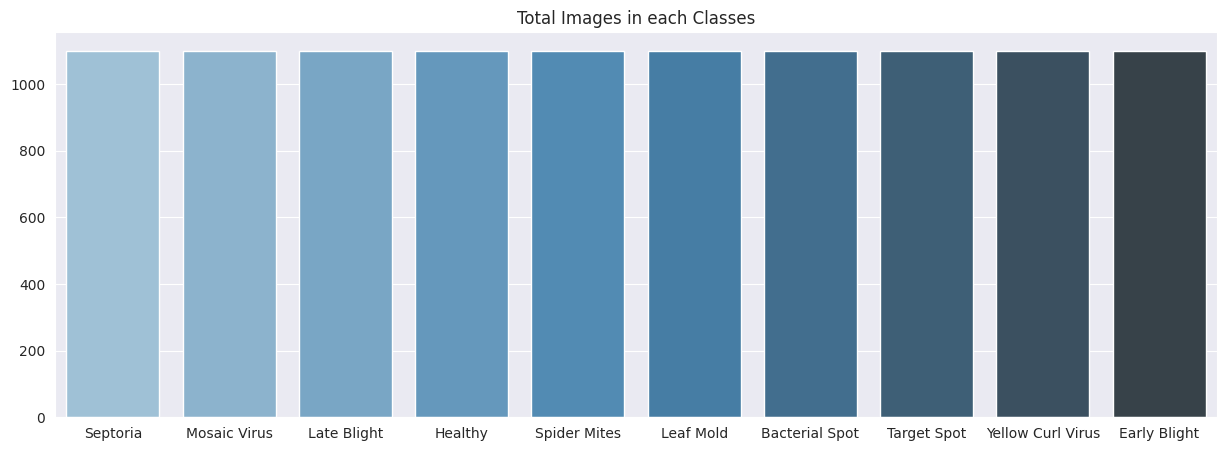

In [14]:
# checking all merged sub dir size
merged_path = '/content/Merged Dataset'

print(f'Total images : {total_count}')
print(f'Total number of classes : {len(os.listdir(merged_path))}')

classes = []
classes_count = []
for sub_dir in os.listdir(merged_path):
  print(f'Total {sub_dir} : {len(os.listdir(os.path.join(merged_path, sub_dir)))}')
  classes.append(sub_dir)
  classes_count.append(len(os.listdir(os.path.join(merged_path, sub_dir))))

plt.figure(figsize = (15,5))
sns.set_style('darkgrid')
sns.barplot(x = classes, y = classes_count, palette = 'Blues_d')
plt.title('Total Images in each Classes')
plt.show()

Image dimensions: (256, 256, 3)


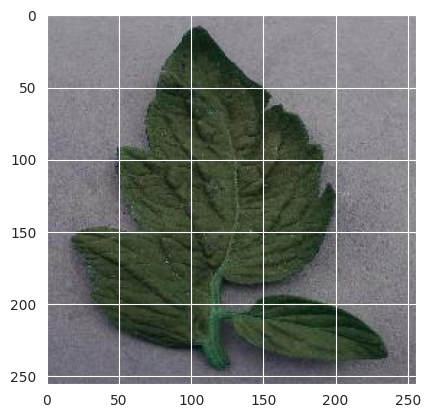

In [15]:
sample_img = cv2.imread('/content/Merged Dataset/Bacterial Spot/00416648-be6e-4bd4-bc8d-82f43f8a7240___GCREC_Bact.Sp 3110.JPG')
plt.imshow(sample_img)
print(f'Image dimensions: {sample_img.shape}')

In [16]:
def load_random_img(dir, label):
  plt.figure(figsize = (18,15))
  i = 0
  for label in classes:
    i += 1
    plt.subplot(1, 10, i)
    file = random.choice(os.listdir(f'{dir}/{label}'))
    image_path = os.path.join(f'{dir}/{label}', file)
    image = cv2.imread(image_path)
    plt.title(label)
    plt.imshow(image)
    plt.grid(None)
    plt.axis('off')

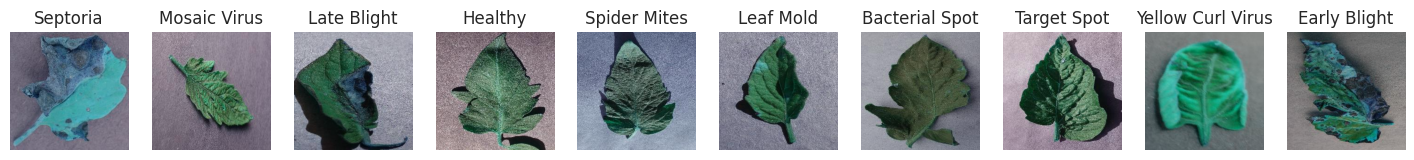

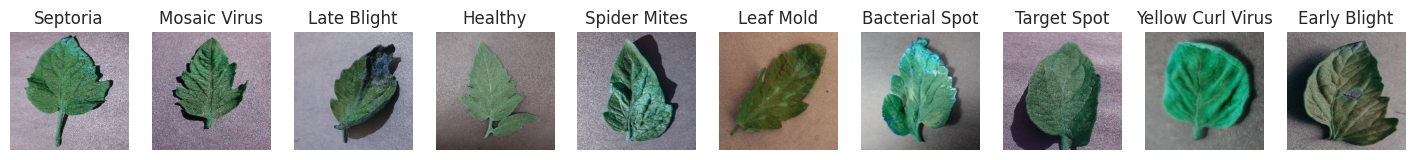

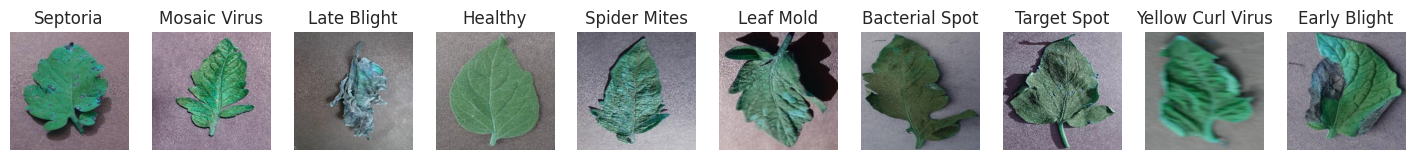

In [17]:
for i in range(3):
  load_random_img(merged_path, classes)

# Splitting Merged Dataset into Train, Val, and Test

In [18]:
base_ds = pathlib.Path('/content/Merged Dataset')
splitfolders.ratio(base_ds, output='Splitting Dataset', seed=123, ratio=(.8,.1,.1), group_prefix=None)

Copying files: 11000 files [00:03, 3170.92 files/s]


# Preprocessing and Augmentation

In [19]:
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001
IMG_DIMENSION = 224
INPUT_SHAPE = (IMG_DIMENSION, IMG_DIMENSION, 3)
NUM_CLASSES = 10

In [20]:
data_generator = ImageDataGenerator(vertical_flip=True,
                                    horizontal_flip=True,
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.2)

In [21]:
train = data_generator.flow_from_directory('/content/Splitting Dataset/train',
                                           target_size=(IMG_DIMENSION, IMG_DIMENSION),
                                           batch_size=BATCH_SIZE,
                                           subset='training')

Found 8800 images belonging to 10 classes.


In [22]:
val = data_generator.flow_from_directory('/content/Splitting Dataset/val',
                                         target_size=(IMG_DIMENSION, IMG_DIMENSION),
                                         batch_size=BATCH_SIZE,
                                         class_mode='categorical',
                                         shuffle=False)

Found 1100 images belonging to 10 classes.


In [23]:
test = data_generator.flow_from_directory('/content/Splitting Dataset/test',
                                          target_size=(IMG_DIMENSION, IMG_DIMENSION),
                                          batch_size=BATCH_SIZE,
                                          class_mode='categorical',
                                          shuffle=False)

Found 1100 images belonging to 10 classes.


# Modelling

In [24]:
base_model = RegNetY016(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

# Freeze the pretrained weights
base_model.trainable = False

base_model_output = base_model.output

# Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(base_model_output)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
x = Flatten()(base_model_output)
x = Dense(512, activation='relu')(x)
x = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

42641688/42641688 [==============================] - 3s 0us/step


In [25]:
checkpointer = ModelCheckpoint(filepath='/content/saved_models/best_model.hdf5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=2)
callbacks = [checkpointer, early_stopping]

In [26]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 regnety016_prestem_rescaling (  (None, 224, 224, 3)  0          ['input_1[0][0]']                
 Rescaling)                                                                                       
                                                                                                  
 regnety016_stem_conv (Conv2D)  (None, 112, 112, 32  864         ['regnety016_prestem_rescaling[0]
                                )                                [0]']                        

In [28]:
history = model.fit(train,
                    validation_data=val,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks)

Epoch 1/20
275/275 [==============================] - ETA: 0s - loss: 2.1890 - accuracy: 0.7110
Epoch 1: val_accuracy improved from -inf to 0.85182, saving model to /content/saved_models/best_model.hdf5
275/275 [==============================] - 167s 535ms/step - loss: 2.1890 - accuracy: 0.7110 - val_loss: 0.4687 - val_accuracy: 0.8518
Epoch 2/20
275/275 [==============================] - ETA: 0s - loss: 0.4229 - accuracy: 0.8559
Epoch 2: val_accuracy did not improve from 0.85182
275/275 [==============================] - 136s 496ms/step - loss: 0.4229 - accuracy: 0.8559 - val_loss: 0.5726 - val_accuracy: 0.8200
Epoch 3/20
275/275 [==============================] - ETA: 0s - loss: 0.3653 - accuracy: 0.8753
Epoch 3: val_accuracy improved from 0.85182 to 0.86000, saving model to /content/saved_models/best_model.hdf5
275/275 [==============================] - 139s 507ms/step - loss: 0.3653 - accuracy: 0.8753 - val_loss: 0.4368 - val_accuracy: 0.8600
Epoch 4/20
275/275 [===================

In [29]:
def plot_train_history(history):
  plt.figure(figsize=(15,5))
  plt.subplot(1,2,1)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')

  plt.subplot(1,2,2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

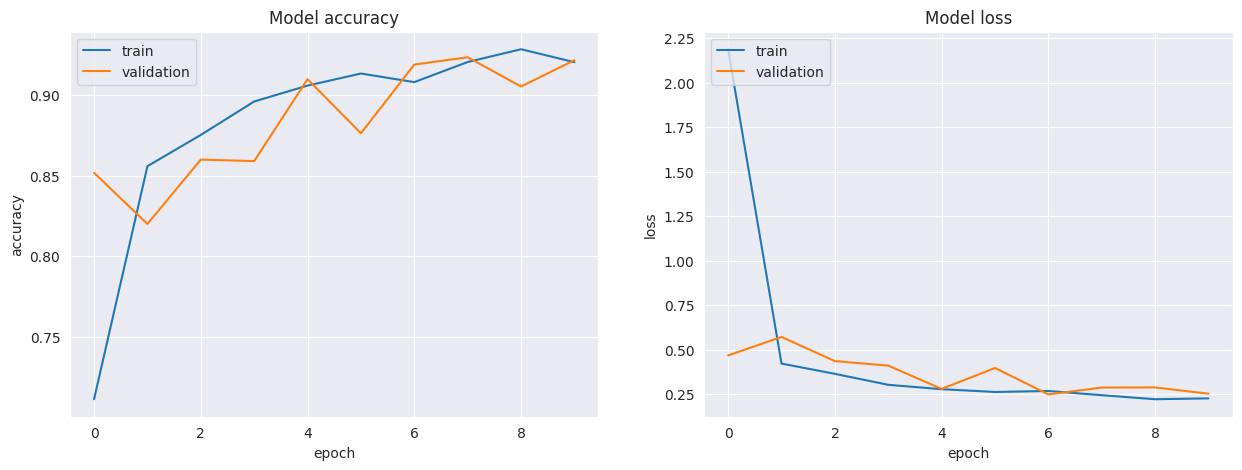

In [30]:
plot_train_history(history)

# Fine-Tuning the Pre-Trained Models

In [31]:
# Unfreeze the top 20% layers
base_model.trainable = True
fine_tune_at = int(len(base_model.layers)*0.8)

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [32]:
# Compile model again after unfreeze some layers
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE/10),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [33]:
fine_tune_epochs = 20

fine_tuning_history = model.fit(train,
                                validation_data=val,
                                batch_size=BATCH_SIZE,
                                epochs=EPOCHS + fine_tune_epochs,
                                initial_epoch=history.epoch[-1] + 1,
                                callbacks=callbacks)

Epoch 11/40
275/275 [==============================] - ETA: 0s - loss: 0.2961 - accuracy: 0.9023
Epoch 11: val_accuracy improved from 0.92364 to 0.93545, saving model to /content/saved_models/best_model.hdf5
275/275 [==============================] - 157s 531ms/step - loss: 0.2961 - accuracy: 0.9023 - val_loss: 0.2062 - val_accuracy: 0.9355
Epoch 12/40
275/275 [==============================] - ETA: 0s - loss: 0.1593 - accuracy: 0.9474
Epoch 12: val_accuracy improved from 0.93545 to 0.94818, saving model to /content/saved_models/best_model.hdf5
275/275 [==============================] - 141s 512ms/step - loss: 0.1593 - accuracy: 0.9474 - val_loss: 0.1892 - val_accuracy: 0.9482
Epoch 13/40
275/275 [==============================] - ETA: 0s - loss: 0.1147 - accuracy: 0.9607
Epoch 13: val_accuracy improved from 0.94818 to 0.95909, saving model to /content/saved_models/best_model.hdf5
275/275 [==============================] - 143s 520ms/step - loss: 0.1147 - accuracy: 0.9607 - val_loss: 0

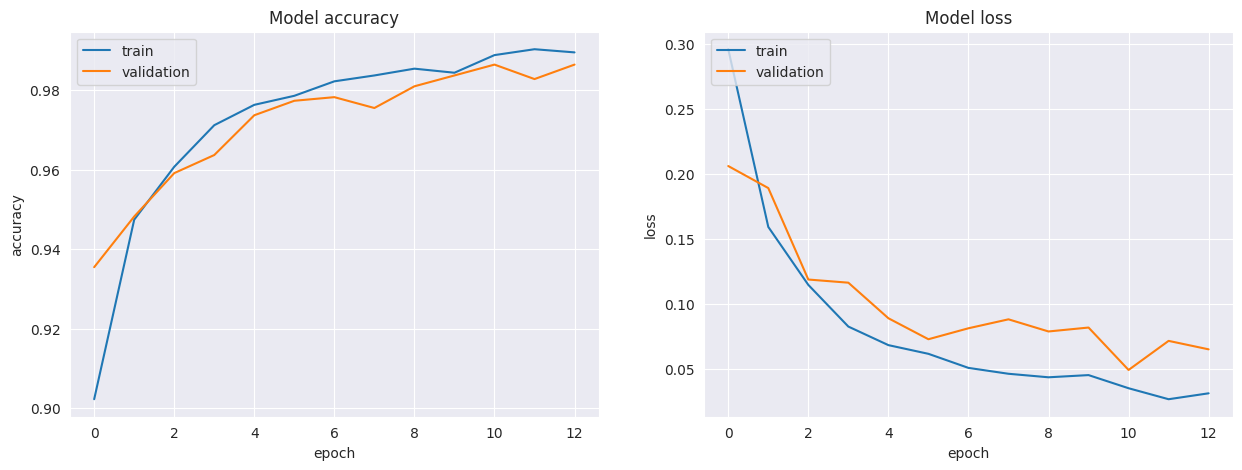

In [34]:
plot_train_history(fine_tuning_history)

# Evaluating the Model

In [35]:
# Checking model best performance score with data test
model.load_weights('/content/saved_models/best_model.hdf5')
score = model.evaluate(test, verbose=1)

35/35 [==============================] - 15s 419ms/step - loss: 0.0810 - accuracy: 0.9764


35/35 [==============================] - 17s 408ms/step


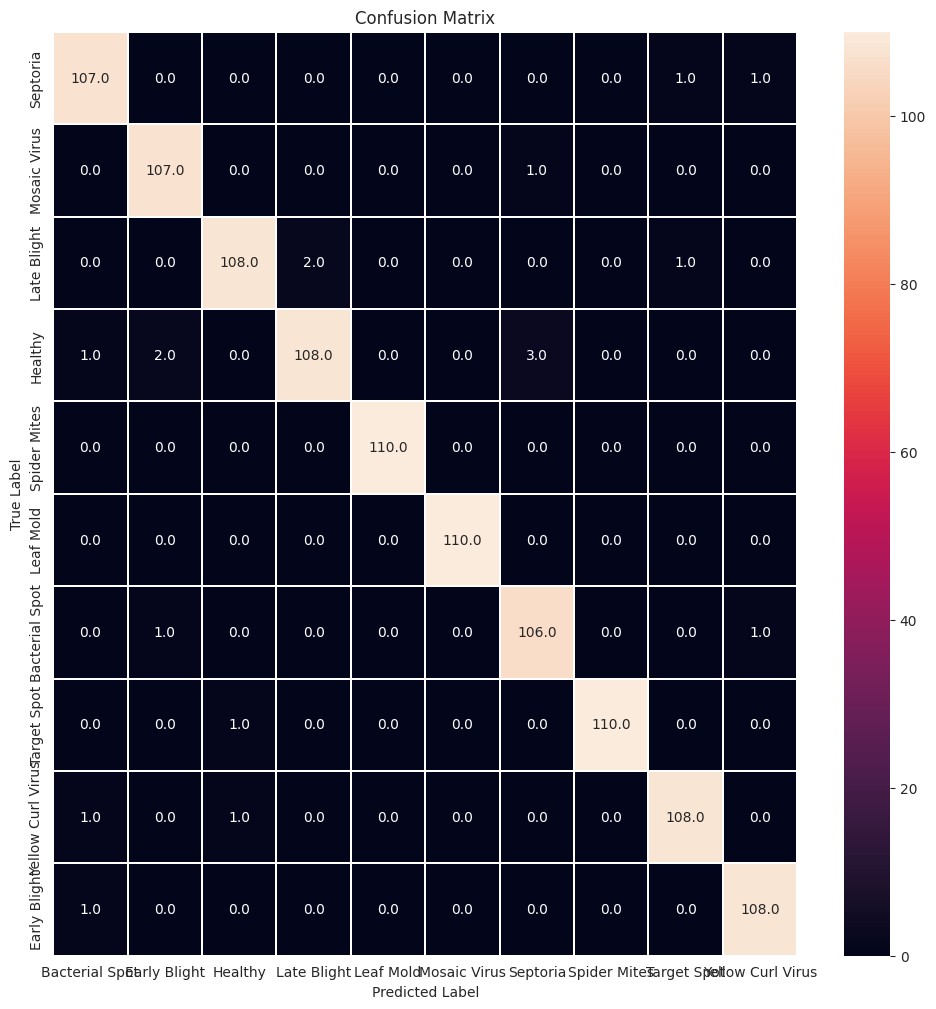

In [36]:
# Evaluating model with confusion matrix
Y_pred = model.predict(test)
y_pred = np.argmax(Y_pred, axis=1)
conf_matrix = confusion_matrix(y_pred, test.classes)

# Make Heatmap
f, ax = plt.subplots(figsize=(12,12))
sns.heatmap(conf_matrix, annot=True, linewidths=0.01, linecolor='white', fmt='.1f', ax=ax)
sns.color_palette('rocket', as_cmap=True)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
ax.xaxis.set_ticklabels(test.class_indices)
ax.yaxis.set_ticklabels(classes)
plt.title('Confusion Matrix')
plt.show()

In [37]:
# Make classification report in dataframe
report = classification_report(test.classes, y_pred, target_names=classes, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Septoria,0.981651,0.972727,0.977169,110.000000
Mosaic Virus,0.990741,0.972727,0.981651,110.000000
Late Blight,0.972973,0.981818,0.977376,110.000000
Healthy,0.947368,0.981818,0.964286,110.000000
Spider Mites,1.000000,1.000000,1.000000,110.000000
Leaf Mold,1.000000,1.000000,1.000000,110.000000
Bacterial Spot,0.981481,0.963636,0.972477,110.000000
Target Spot,0.990991,1.000000,0.995475,110.000000
Yellow Curl Virus,0.981818,0.981818,0.981818,110.000000
Early Blight,0.990826,0.981818,0.986301,110.000000
